In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import shutil
folder_paths = [x[0] for x in os.walk('/content/drive/MyDrive/Image Processing/GAN')]

In [ ]:
folder_paths

['/content/drive/MyDrive/Image Processing/GAN',
 '/content/drive/MyDrive/Image Processing/GAN/0',
 '/content/drive/MyDrive/Image Processing/GAN/1',
 '/content/drive/MyDrive/Image Processing/GAN/2',
 '/content/drive/MyDrive/Image Processing/GAN/3',
 '/content/drive/MyDrive/Image Processing/GAN/4',
 '/content/drive/MyDrive/Image Processing/GAN/5']

In [ ]:
# Extract the artist names from the paths
artists = [os.path.basename(path).replace('_', ' ') for path in folder_paths[1:]]

# Print the list of artists
print(artists)

['0', '1', '2', '3', '4', '5']


In [ ]:
DATA_DIR = '/content/paintings/images'

if not os.path.exists(DATA_DIR):
  os.makedirs(DATA_DIR)

for folder_path in folder_paths:
  for filename in os.listdir(folder_path):
    if filename.endswith('.jpg') or filename.endswith('.png'):
      src_path = os.path.join(folder_path, filename)
      dst_path = os.path.join(DATA_DIR, filename)
      shutil.copy(src_path, dst_path)

In [ ]:
valid_extensions = ('.jpg', '.png')

# Get the list of all files in the folder with valid extensions
files = [file for file in os.listdir(DATA_DIR) if file.endswith(valid_extensions)]

# Print the total number of images in the folder
print(f'Total number of images in {DATA_DIR}: {len(files)}')

Total number of images in /content/paintings/images: 57838


In [ ]:
print(os.listdir(DATA_DIR)[:10])

['cs1416079017964514624.jpg', 'cs13129418041517285155.jpg', 'cs11642271500921945281.jpg', 'cs2423159578819388102.jpg', 'cs13240397482063270707.jpg', 'cs16102299904276718846.jpg', 'cs3925428940012020560.jpg', 'cs2448848613852561012.jpg', 'cs13074707230251676205.jpg', 'cs12860897457959625157.jpg']


In [ ]:
folder_path = DATA_DIR

total_width = 0
total_height = 0
num_images = 0

# loop through all images in the folder
for filename in os.listdir(folder_path):
    if filename.endswith(".jpg") or filename.endswith(".png"):
        # open the image
        image = Image.open(os.path.join(folder_path, filename))

        # get the shape (dimensions) of the image
        width, height = image.size

        # accumulate the total width and height
        total_width += width
        total_height += height

        # increment the number of images
        num_images += 1

# calculate the mean dimensions
mean_width = total_width / num_images
mean_height = total_height / num_images

# print the mean dimensions
print(f"The mean dimensions of the {num_images} images are {mean_width}x{mean_height}")

The mean dimensions of the 57838 images are 500.0x500.0


In [ ]:
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T

In [ ]:
image_size = 128
batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [ ]:
train_ds = ImageFolder('/content/paintings', transform=T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.ToTensor(),
    T.Normalize(*stats)]))

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

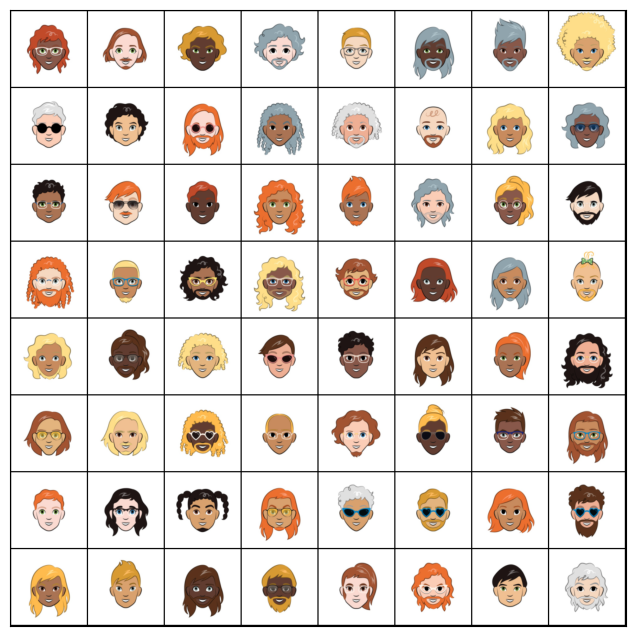

In [ ]:
show_batch(train_dl)

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
device = get_default_device()
device

device(type='cuda')

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)

In [ ]:
import torch.nn as nn

In [ ]:
discriminator = nn.Sequential(
    # in: 3 x 128 x 128
    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 64 x 64

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 32 x 32

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 16 x 16

    nn.Conv2d(256, 512, kernel_size=4, stride=4, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 8 x 8

    nn.Conv2d(512, 1, kernel_size=4, stride=4, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid()
)


In [ ]:
discriminator = to_device(discriminator, device)

In [ ]:
latent_size = 128

In [ ]:
generator = nn.Sequential(
    # in: latent_size x 1 x 1
    nn.ConvTranspose2d(latent_size, 1024, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(1024),
    nn.ReLU(True),
    # out: 1024 x 4 x 4

    nn.ConvTranspose2d(1024, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 8 x 8

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 16 x 16

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 32 x 32

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=4, padding=0, bias=False),
    nn.Tanh()
    # out: 3 x 128 x 128
)

torch.Size([128, 3, 128, 128])


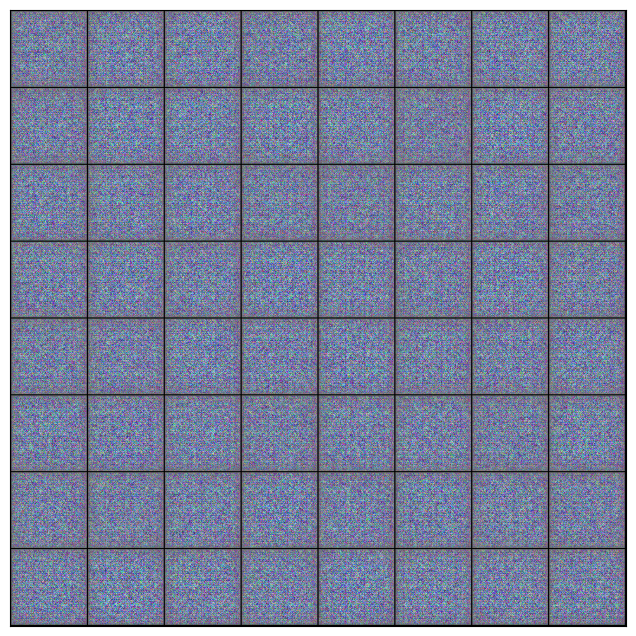

In [ ]:
xb = torch.randn(batch_size, latent_size, 1, 1) # random latent tensors
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

In [ ]:
generator = to_device(generator, device)

In [ ]:
def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    batch_size = real_images.size(0)
    # Create target tensors
    real_targets = torch.ones(batch_size, 1, device=device)
    fake_targets = torch.zeros(batch_size, 1, device=device)

    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()

    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Pass fake images through discriminator
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()

    return loss.item(), real_score, fake_score


In [ ]:
def train_generator(opt_g):
    # Clear generator gradients
    opt_g.zero_grad()

    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)

    # Update generator weights
    loss.backward()
    opt_g.step()

    return loss.item()

In [ ]:
from torchvision.utils import save_image

In [ ]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [ ]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [ ]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

Saving generated-images-0000.png


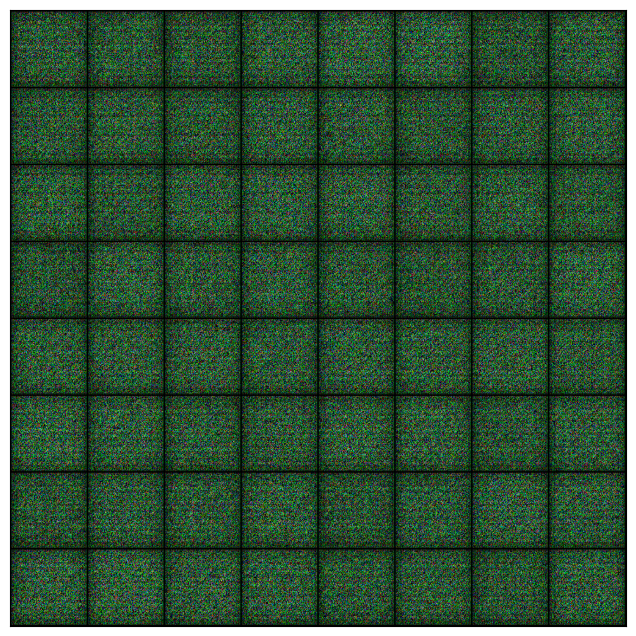

In [ ]:
save_samples(0, fixed_latent)

In [ ]:
from tqdm.notebook import tqdm
import torch.nn.functional as F

In [ ]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()

    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []

    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))

    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)

        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)

        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))

        # Save generated images
        save_samples(epoch+start_idx, fixed_latent, show=False)

    return losses_g, losses_d, real_scores, fake_scores

In [ ]:
lr = 0.0002
epochs = 50

In [ ]:
history = fit(epochs, lr)

  0%|          | 0/452 [00:00<?, ?it/s]

Epoch [1/50], loss_g: 8.5538, loss_d: 0.0010, real_score: 0.9993, fake_score: 0.0003
Saving generated-images-0001.png


  0%|          | 0/452 [00:00<?, ?it/s]

Epoch [2/50], loss_g: 6.9906, loss_d: 0.0014, real_score: 0.9997, fake_score: 0.0011
Saving generated-images-0002.png


  0%|          | 0/452 [00:00<?, ?it/s]

Epoch [3/50], loss_g: 8.5627, loss_d: 0.0004, real_score: 0.9999, fake_score: 0.0002
Saving generated-images-0003.png


  0%|          | 0/452 [00:00<?, ?it/s]

Epoch [4/50], loss_g: 2.6640, loss_d: 0.3656, real_score: 0.8185, fake_score: 0.1409
Saving generated-images-0004.png


  0%|          | 0/452 [00:00<?, ?it/s]

Epoch [5/50], loss_g: 1.6962, loss_d: 0.4269, real_score: 0.7555, fake_score: 0.0760
Saving generated-images-0005.png


  0%|          | 0/452 [00:00<?, ?it/s]

Epoch [6/50], loss_g: 3.5970, loss_d: 0.1989, real_score: 0.8426, fake_score: 0.0110
Saving generated-images-0006.png


  0%|          | 0/452 [00:00<?, ?it/s]

Epoch [7/50], loss_g: 3.4326, loss_d: 0.1470, real_score: 0.9130, fake_score: 0.0469
Saving generated-images-0007.png


  0%|          | 0/452 [00:00<?, ?it/s]

Epoch [8/50], loss_g: 3.7243, loss_d: 0.1353, real_score: 0.9652, fake_score: 0.0909
Saving generated-images-0008.png


  0%|          | 0/452 [00:00<?, ?it/s]

Epoch [9/50], loss_g: 2.1101, loss_d: 5.1196, real_score: 0.0172, fake_score: 0.0000
Saving generated-images-0009.png


  0%|          | 0/452 [00:00<?, ?it/s]

Epoch [10/50], loss_g: 4.7810, loss_d: 0.1084, real_score: 0.9650, fake_score: 0.0664
Saving generated-images-0010.png


  0%|          | 0/452 [00:00<?, ?it/s]

Epoch [11/50], loss_g: 4.9081, loss_d: 0.0415, real_score: 0.9762, fake_score: 0.0168
Saving generated-images-0011.png


  0%|          | 0/452 [00:00<?, ?it/s]

Epoch [12/50], loss_g: 4.2367, loss_d: 0.0988, real_score: 0.9431, fake_score: 0.0354
Saving generated-images-0012.png


  0%|          | 0/452 [00:00<?, ?it/s]

Epoch [13/50], loss_g: 5.2431, loss_d: 0.0131, real_score: 0.9923, fake_score: 0.0053
Saving generated-images-0013.png


  0%|          | 0/452 [00:00<?, ?it/s]

Epoch [14/50], loss_g: 5.0025, loss_d: 0.0245, real_score: 0.9884, fake_score: 0.0126
Saving generated-images-0014.png


  0%|          | 0/452 [00:00<?, ?it/s]

Epoch [15/50], loss_g: 5.5666, loss_d: 0.0218, real_score: 0.9966, fake_score: 0.0181
Saving generated-images-0015.png


  0%|          | 0/452 [00:00<?, ?it/s]

Epoch [16/50], loss_g: 5.6177, loss_d: 0.0140, real_score: 0.9946, fake_score: 0.0085
Saving generated-images-0016.png


  0%|          | 0/452 [00:00<?, ?it/s]

Epoch [17/50], loss_g: 3.7412, loss_d: 0.0815, real_score: 0.9673, fake_score: 0.0453
Saving generated-images-0017.png


  0%|          | 0/452 [00:00<?, ?it/s]

Epoch [18/50], loss_g: 3.9178, loss_d: 0.0792, real_score: 0.9489, fake_score: 0.0208
Saving generated-images-0018.png


  0%|          | 0/452 [00:00<?, ?it/s]

Epoch [19/50], loss_g: 6.0219, loss_d: 0.0223, real_score: 0.9903, fake_score: 0.0124
Saving generated-images-0019.png


  0%|          | 0/452 [00:00<?, ?it/s]

Epoch [20/50], loss_g: 5.7065, loss_d: 0.0149, real_score: 0.9954, fake_score: 0.0102
Saving generated-images-0020.png


  0%|          | 0/452 [00:00<?, ?it/s]

Epoch [21/50], loss_g: 6.6647, loss_d: 0.1451, real_score: 0.9670, fake_score: 0.1017
Saving generated-images-0021.png


  0%|          | 0/452 [00:00<?, ?it/s]

Epoch [22/50], loss_g: 0.5707, loss_d: 3.1331, real_score: 0.1698, fake_score: 0.0000
Saving generated-images-0022.png


  0%|          | 0/452 [00:00<?, ?it/s]

Epoch [23/50], loss_g: 6.6914, loss_d: 0.0411, real_score: 0.9693, fake_score: 0.0062
Saving generated-images-0023.png


  0%|          | 0/452 [00:00<?, ?it/s]

Epoch [24/50], loss_g: 4.9357, loss_d: 0.0838, real_score: 0.9678, fake_score: 0.0424
Saving generated-images-0024.png


  0%|          | 0/452 [00:00<?, ?it/s]

Epoch [25/50], loss_g: 4.9095, loss_d: 0.0430, real_score: 0.9779, fake_score: 0.0199
Saving generated-images-0025.png


  0%|          | 0/452 [00:00<?, ?it/s]

Epoch [26/50], loss_g: 4.1792, loss_d: 0.0542, real_score: 0.9706, fake_score: 0.0204
Saving generated-images-0026.png


  0%|          | 0/452 [00:00<?, ?it/s]

Epoch [27/50], loss_g: 4.1197, loss_d: 0.0677, real_score: 0.9483, fake_score: 0.0123
Saving generated-images-0027.png


  0%|          | 0/452 [00:00<?, ?it/s]

Epoch [28/50], loss_g: 35.7247, loss_d: 2.5346, real_score: 1.0000, fake_score: 0.8411
Saving generated-images-0028.png


  0%|          | 0/452 [00:00<?, ?it/s]

Epoch [29/50], loss_g: 6.0614, loss_d: 0.0100, real_score: 0.9958, fake_score: 0.0056
Saving generated-images-0029.png


  0%|          | 0/452 [00:00<?, ?it/s]

Epoch [30/50], loss_g: 6.4372, loss_d: 0.0130, real_score: 0.9977, fake_score: 0.0105
Saving generated-images-0030.png


  0%|          | 0/452 [00:00<?, ?it/s]

Epoch [31/50], loss_g: 5.2384, loss_d: 0.0214, real_score: 0.9925, fake_score: 0.0136
Saving generated-images-0031.png


  0%|          | 0/452 [00:00<?, ?it/s]

Epoch [32/50], loss_g: 6.0022, loss_d: 0.0103, real_score: 0.9947, fake_score: 0.0049
Saving generated-images-0032.png


  0%|          | 0/452 [00:00<?, ?it/s]

Epoch [33/50], loss_g: 5.1471, loss_d: 0.0254, real_score: 0.9836, fake_score: 0.0087
Saving generated-images-0033.png


  0%|          | 0/452 [00:00<?, ?it/s]

Epoch [34/50], loss_g: 5.3187, loss_d: 0.0503, real_score: 0.9604, fake_score: 0.0084
Saving generated-images-0034.png


  0%|          | 0/452 [00:00<?, ?it/s]

Epoch [35/50], loss_g: 3.8737, loss_d: 0.0456, real_score: 0.9658, fake_score: 0.0051
Saving generated-images-0035.png


  0%|          | 0/452 [00:00<?, ?it/s]

Epoch [36/50], loss_g: 6.6593, loss_d: 0.0051, real_score: 0.9971, fake_score: 0.0021
Saving generated-images-0036.png


  0%|          | 0/452 [00:00<?, ?it/s]

Epoch [37/50], loss_g: 7.3969, loss_d: 0.1136, real_score: 0.9561, fake_score: 0.0099
Saving generated-images-0037.png


  0%|          | 0/452 [00:00<?, ?it/s]

Epoch [38/50], loss_g: 4.1549, loss_d: 0.0101, real_score: 0.9966, fake_score: 0.0067
Saving generated-images-0038.png


  0%|          | 0/452 [00:00<?, ?it/s]

Epoch [39/50], loss_g: 4.8880, loss_d: 0.0104, real_score: 0.9939, fake_score: 0.0042
Saving generated-images-0039.png


  0%|          | 0/452 [00:00<?, ?it/s]

Epoch [40/50], loss_g: 5.6846, loss_d: 0.0235, real_score: 0.9924, fake_score: 0.0156
Saving generated-images-0040.png


  0%|          | 0/452 [00:00<?, ?it/s]

Epoch [41/50], loss_g: 11.8164, loss_d: 0.7494, real_score: 0.7129, fake_score: 0.0015
Saving generated-images-0041.png


  0%|          | 0/452 [00:00<?, ?it/s]

Epoch [42/50], loss_g: 6.7616, loss_d: 0.0182, real_score: 0.9951, fake_score: 0.0131
Saving generated-images-0042.png


  0%|          | 0/452 [00:00<?, ?it/s]

Epoch [43/50], loss_g: 5.9584, loss_d: 0.0126, real_score: 0.9950, fake_score: 0.0075
Saving generated-images-0043.png


  0%|          | 0/452 [00:00<?, ?it/s]

Epoch [44/50], loss_g: 5.4008, loss_d: 0.0064, real_score: 0.9967, fake_score: 0.0031
Saving generated-images-0044.png


  0%|          | 0/452 [00:00<?, ?it/s]

Epoch [45/50], loss_g: 4.4308, loss_d: 0.1235, real_score: 0.9151, fake_score: 0.0277
Saving generated-images-0045.png


  0%|          | 0/452 [00:00<?, ?it/s]

Epoch [46/50], loss_g: 7.3483, loss_d: 0.0375, real_score: 0.9940, fake_score: 0.0305
Saving generated-images-0046.png


  0%|          | 0/452 [00:00<?, ?it/s]

Epoch [47/50], loss_g: 7.0456, loss_d: 0.0079, real_score: 0.9957, fake_score: 0.0035
Saving generated-images-0047.png


  0%|          | 0/452 [00:00<?, ?it/s]

Epoch [48/50], loss_g: 6.3115, loss_d: 0.0112, real_score: 0.9944, fake_score: 0.0055
Saving generated-images-0048.png


  0%|          | 0/452 [00:00<?, ?it/s]

Epoch [49/50], loss_g: 5.6017, loss_d: 0.0170, real_score: 0.9927, fake_score: 0.0095
Saving generated-images-0049.png


  0%|          | 0/452 [00:00<?, ?it/s]

Epoch [50/50], loss_g: 6.6899, loss_d: 0.0046, real_score: 0.9974, fake_score: 0.0020
Saving generated-images-0050.png


In [ ]:
losses_g, losses_d, real_scores, fake_scores = history

In [ ]:
# Save the model checkpoints
torch.save(generator.state_dict(), 'G.pth')
torch.save(discriminator.state_dict(), 'D.pth')

In [ ]:
import cv2
import os

vid_fname = 'gans_training.avi'

files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'generated' in f]
files.sort()

out = cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'MP4V'), 1, (530,530))
[out.write(cv2.imread(fname)) for fname in files]
out.release()

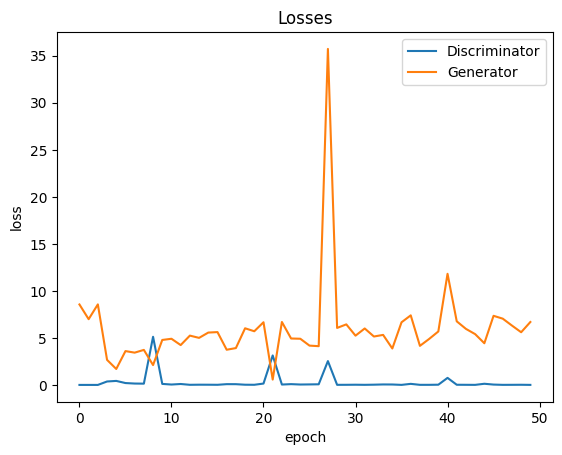

In [ ]:
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')

plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

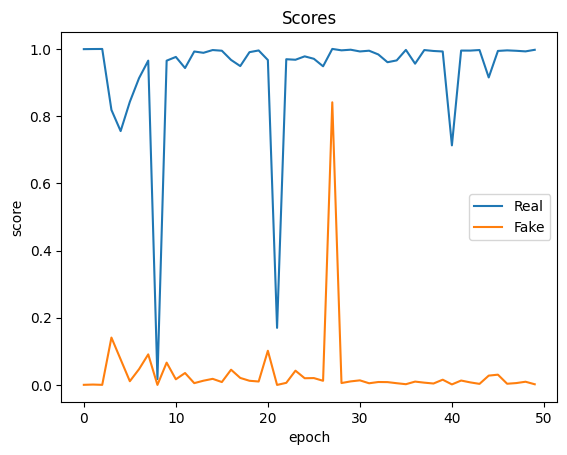

In [ ]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');

In [ ]:
!zip -r /content/generated.zip /content/generated
from google.colab import files

files.download("/content/generated.zip")

  adding: content/generated/ (stored 0%)
  adding: content/generated/generated-images-0042.png (deflated 0%)
  adding: content/generated/generated-images-0010.png (deflated 0%)
  adding: content/generated/generated-images-0036.png (deflated 0%)
  adding: content/generated/generated-images-0013.png (deflated 0%)
  adding: content/generated/generated-images-0019.png (deflated 0%)
  adding: content/generated/generated-images-0030.png (deflated 0%)
  adding: content/generated/generated-images-0027.png (deflated 0%)
  adding: content/generated/generated-images-0021.png (deflated 0%)
  adding: content/generated/generated-images-0034.png (deflated 0%)
  adding: content/generated/generated-images-0009.png (deflated 0%)
  adding: content/generated/generated-images-0035.png (deflated 0%)
  adding: content/generated/generated-images-0043.png (deflated 0%)
  adding: content/generated/generated-images-0014.png (deflated 0%)
  adding: content/generated/generated-images-0005.png (deflated 0%)
  addin

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
files.download('/content/D.pth')
files.download('/content/G.pth')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>